# 1. Data Preparation

## 1.1 Import data

In [1]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
dataset_path = data_path / "MNIST-datasets"

# If the MNIST-datasets folder doesn't exist, create it
if dataset_path.is_dir():
    print(f"{dataset_path} directory exists.")
else:
    print(f"Did not find {dataset_path} directory, creating one...")
    dataset_path.mkdir(parents=True, exist_ok=True)

    # Download data
    with open(data_path / "MNIST-datasets.zip", "wb") as f:
        request = requests.get("https://github.com/SurawutK/Kaggle-Projects/raw/refs/heads/main/datasets/MNIST-datasets/MNIST-datasets.zip")
        print("Downloading dataset")
        f.write(request.content)

    # Unzip data
    with zipfile.ZipFile(data_path / "MNIST-datasets.zip", "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(dataset_path)

data/MNIST-datasets directory exists.


In [2]:
# Import dataset (train.csv)
import pandas as pd

dataset = pd.read_csv('./data/MNIST-datasets/train.csv')
dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.2 Split dataset into train and validation set

In [3]:
# split data into train / validation set
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(dataset,
                                               test_size=0.2,
                                               shuffle=True,
                                               stratify=dataset['label'],
                                               random_state=42
                                              )

train_dataset.shape, val_dataset.shape

((33600, 785), (8400, 785))

## 1.3 Create PyTorch custom dataset class from our data

In [4]:
'label' in dataset.columns

True

In [5]:
# Create Custom Dataset Class for DataLoader
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class MNIST(Dataset):
    def __init__(self, dataframe:pd.DataFrame, transform=None):
        self.data = dataframe
        self.transform = transform
        self.features = self.data.iloc[:, 1:].to_numpy().reshape((-1, 28, 28, 1))
        self.targets = self.data.iloc[:, 0].to_numpy()
        self.classes = np.unique(self.targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.features[idx].astype(np.uint8)
        y = torch.tensor(self.targets[idx]).type(torch.LongTensor)

        if self.transform:
            X = self.transform(X)

        return X, y

In [6]:
# Create datasets from class, and transform features into tensors value range [0-1]
import torch
from torchvision.transforms import ToTensor

train_set = MNIST(train_dataset, transform=ToTensor())
val_set = MNIST(val_dataset, transform=ToTensor())

In [7]:
# size of datasets
print(f'Train set size: {len(train_set)}')
print(f'Test set size: {len(val_set)}')

Train set size: 33600
Test set size: 8400


In [8]:
image_0, label_0 = train_set[0]

print(f'Shape: {image_0.shape}, Dtype: {image_0.dtype}')
print(f'Shape: {label_0.shape}, Dtype: {label_0.dtype}')

Shape: torch.Size([1, 28, 28]), Dtype: torch.float32
Shape: torch.Size([]), Dtype: torch.int64


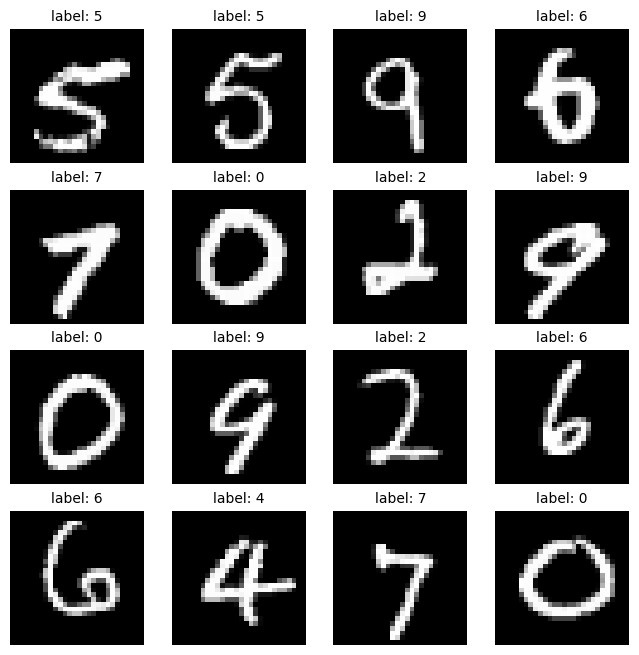

In [9]:
# visualize random sample images from train set
import torch
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

plt.figure(figsize=(8,8))

for i in range(nrows*ncols):
    random_idx = torch.randint(0, len(train_set), size=[1]).item()
    image, label = train_set[random_idx]
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'label: {label}', fontsize=10)
    plt.axis(False);

## 1.4 Create dataloaders from PyTorch datasets

In [10]:
# DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [11]:
# size of datasets
print(f'Number of batches in train set: {len(train_dataloader)}')
print(f'Number of batches in val set: {len(val_dataloader)}')

Number of batches in train set: 1050
Number of batches in val set: 263


In [12]:
# first batch of a train set
images_batch_0, labels_batch_0 = next(iter(train_dataloader))

print(f'Shape: {images_batch_0.shape}')
print(f'Shape: {labels_batch_0.shape}')

Shape: torch.Size([32, 1, 28, 28])
Shape: torch.Size([32])


# 2. Build Model

## 2.1 Build and Initialize the model

In [13]:
# insatll torchmetrics
! pip install torchmetrics

In [14]:
import torch
from torch import nn
import torchmetrics

# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Build a model (simulation of the VGG-16 architecture but quite smaller 'TinyVGG')
class MNISTModel(nn.Module):
    def __init__(self, input_channels:int, output_classes:int, n_h:int = 64):
        super().__init__()
        # Conv_1: [3 x 3 Conv + Relu 64] x 2 -> [2 x 2 Max-Pool s=2]
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=64,
                      kernel_size=(3, 3),
                      padding='same',
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3, 3),
                      padding='same',
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=2)
        )

        # Conv_2: [3 x 3 Conv + Relu 128] x 2 -> [2 x 2 Max-Pool s=2]
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3,3),
                      padding='same',
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3, 3),
                      padding='same',
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=2)
        )

        # Fully conected layers: [FC 64 (default)] -> [FC 64 (default)] -> [OUTPUT 10]
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*7*7, out_features=n_h),
            nn.ReLU(),
            nn.Linear(in_features=n_h, out_features=n_h),
            nn.ReLU(),
            nn.Linear(in_features=n_h, out_features=output_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.fc_block(x)
        return x

In [15]:
# Initialize model
torch.manual_seed(42)
num_classes = len(train_set.classes)

model = MNISTModel(input_channels=1, n_h=64, output_classes=num_classes)
model.to(device)

MNISTModel(
  (conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)

## 2.2 Build functions for training loop and testing loop

In [16]:
import torch
from torch import nn
from tqdm.auto import tqdm

# Training loop function for an epoch
def training_loop(model, data_loader, cost_fn, optimizer, eval_metrics, device):
    """
    Training loop for 1 epoch.

    Args:
        model (torch.nn.Module):
        data_loader (torch.utils.data.DataLoader):
        cost_fn (torch.nn):
        optimizer (torch.optim):
        eval_metrics (list[(str, torchmetrics)]):
        device (torch.device):
    """
    # put model, eval_metric to device
    model.to(device)
    for name, metric in eval_metrics:
        metric.to(device)

    # train mode
    model.train()

    # cost, error of this epoch
    train_cost_epoch = 0
    train_error_epoch = {name:0 for name, metric in eval_metrics}

    # number of batches in epoch
    num_batches = len(train_dataloader)

    for X_train, y_train in tqdm(train_dataloader,
                                 total=num_batches,
                                 bar_format='{n_fmt}/{total_fmt} {bar} {percentage:.0f}% [{elapsed}<{remaining}, {rate_fmt}]'):
        X_train, y_train = X_train.to(device), y_train.to(device)

        # forward propagation
        y_train_logits = model(X_train)
        y_train_pred = torch.softmax(y_train_logits, dim=1).argmax(dim=1)

        # cost / eval
        train_cost = cost_fn(y_train_logits, y_train)
        train_cost_epoch += train_cost

        for name, metric in eval_metrics:
            train_error_epoch[name] += metric(y_train_pred, y_train)

        # optimizer zero grad
        optimizer.zero_grad()

        # backwazrd prop
        train_cost.backward()

        # update params
        optimizer.step()

    train_cost_epoch /= num_batches
    train_error_epoch = {name: error/num_batches for name, error in train_error_epoch.items()}

    return train_cost_epoch, train_error_epoch

# Testing Loop function for an epoch
def testing_loop(model, data_loader, cost_fn, eval_metrics, device):
    """_summary_

    Args:
        model (torch.nn.Module): _description_
        data_loader (torch.utils.data.DataLoader): _description_
        cost_fn (torch.nn): _description_
        eval_metrics (list[(str, torchmetrics)]): _description_
        device (torch.device): _description_
    """
    # put model, eval_metric to device
    model.to(device)
    for name, metric in eval_metrics:
        metric.to(device)

    # eval mode
    model.eval()

    # cost, error of this epoch
    test_cost_epoch = 0
    test_error_epoch = {name:0 for name, metric in eval_metrics}

    # number of batches in the epoch
    num_batches = len(data_loader)

    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            # forward prop
            y_test_logits = model(X_test)
            y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            # cost / eval metric
            test_cost_epoch += cost_fn(y_test_logits, y_test)

            for name, metric in eval_metrics:
                test_error_epoch[name] += metric(y_test_pred, y_test)

        test_cost_epoch /= num_batches
        test_error_epoch = {name: error/num_batches for name, error in test_error_epoch.items()}

    return test_cost_epoch, test_error_epoch

## 2.3 Build a function for fitting the model

In [17]:
# function for fit the model
def fit(model: torch.nn.Module,
        data: torch.utils.data.DataLoader,
        epochs: int,
        validation_data: torch.utils.data.DataLoader,
        cost_fn: torch.nn,
        optimizer: torch.optim,
        eval_metrics,
        device: torch.device):

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        train_cost, train_errors = training_loop(model=model,
                                    data_loader=data,
                                    cost_fn=cost_fn,
                                    optimizer=optimizer,
                                    eval_metrics=eval_metrics,
                                    device=device)

        test_cost, test_errors = testing_loop(model=model,
                                                data_loader=validation_data,
                                                cost_fn=cost_fn,
                                                eval_metrics=eval_metrics,
                                                device=device)

        ### Print Output
        train_output_text = f'Train cost: {train_cost:.5f}'
        test_output_text = f'Validation cost: {test_cost:.5f}'

        for name, error in train_errors.items():
            train_output_text += f' | Train {name}: {error:.4f}'
        for name, error in test_errors.items():
            test_output_text += f' | Validation {name}: {error:.4f}'

        print(train_output_text)
        print(test_output_text)
        print('\n')

## 2.4 Train model

In [18]:
# function for measure time
from timeit import default_timer as timer

def print_train_time(start:float, end:float, device:torch.device):
    """Prints differents between start and end time.

    Args:
        start (float): start time
        stop (float): end time
        device (torch.device): device
    """
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

In [19]:
# loss function / optimizer / evaluation metrics
import torch
from torch import nn
from torchmetrics import Accuracy

# cost fn
cost_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

# Eval metrics
accuracy_fn = Accuracy(task='multiclass', num_classes=num_classes).to(device)

In [20]:
from timeit import default_timer as timer
import torch

# set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set timer
start_time = timer()

# epochs
epochs = 3

fit(model=model,
    data=train_dataloader,
    epochs=epochs,
    validation_data=val_dataloader,
    cost_fn=cost_fn,
    optimizer=optimizer,
    eval_metrics=[('accuracy', accuracy_fn)],
    device=device)

end_time = timer()
total_train_time = print_train_time(start=start_time, end=end_time, device=device)

Epoch 1/3


0/1050            0% [00:00<?, ?it/s]

Train cost: 0.61444 | Train accuracy: 0.7824
Validation cost: 0.09841 | Validation accuracy: 0.9693


Epoch 2/3


0/1050            0% [00:00<?, ?it/s]

Train cost: 0.07000 | Train accuracy: 0.9788
Validation cost: 0.07403 | Validation accuracy: 0.9771


Epoch 3/3


0/1050            0% [00:00<?, ?it/s]

Train cost: 0.04497 | Train accuracy: 0.9854
Validation cost: 0.07451 | Validation accuracy: 0.9793


Train time on cuda: 31.294 seconds


# 3. Make Predictions and Evaluate the model on Validation Set

In [21]:
#  Make Predictions and Evaluate the model on Validation Set

y_val_preds = []
val_cost = 0
val_accuracy = 0

model.eval()
with torch.inference_mode():
    for X_val, y_val in val_dataloader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        y_val_logits = model(X_val)
        y_val_pred = torch.softmax(y_val_logits, dim=1).argmax(dim=1)
        val_cost += cost_fn(y_val_logits, y_val)
        val_accuracy += accuracy_fn(y_val_pred, y_val)
        y_val_preds.append(y_val_pred.cpu())

    val_cost /= len(val_dataloader)
    val_accuracy /= len(val_dataloader)


y_val_preds = torch.cat(y_val_preds)

print(f"Predictions on validation set: {y_val_preds} | shape: {y_val_preds.shape}")
print(f"Validation loss: {val_cost:.5f}")
print(f"Validation accuracy: {val_accuracy:.4f}")

Predictions on validation set: tensor([1, 8, 6,  ..., 7, 7, 1]) | shape: torch.Size([8400])
Validation loss: 0.07451
Validation accuracy: 0.9793


# 4. Visualize model's predictions on random samples

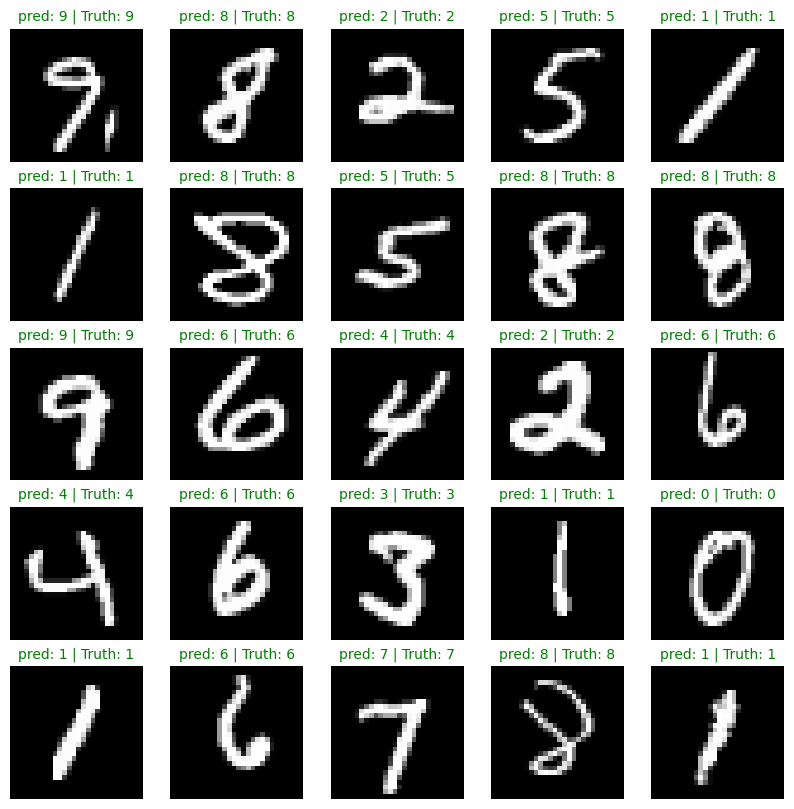

In [22]:
# visualize model predictions vs truth labels on random samples in validation set
import torch
import matplotlib.pyplot as plt

nrows = 5
ncols = 5

plt.figure(figsize=(10,10))

for i in range(nrows*ncols):
    random_idx = torch.randint(0, len(val_set), size=[1]).item()

    # random image and its true label
    image, label = val_set[random_idx]

    # prediction of that random image
    pred = y_val_preds[random_idx].item()

    plt.subplot(nrows, ncols, i+1)
    plt.imshow(image.squeeze(), cmap='gray')

    text_title = f'pred: {pred} | Truth: {label}'

    if pred == label:
        plt.title(text_title, c='g', fontsize=10)
    else:
        plt.title(text_title, c='r', fontsize=10)

    plt.axis(False);

# 5. Making a confusion matrix for further prediction evaluation

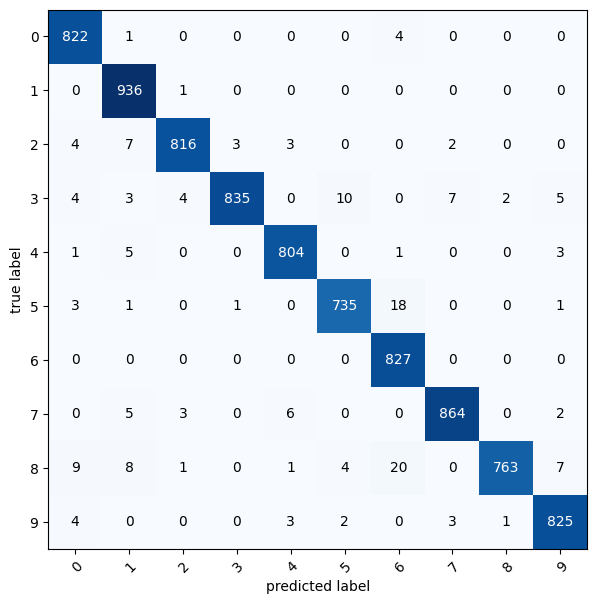

In [23]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_mat_fn = ConfusionMatrix(task='multiclass', num_classes=num_classes)
conf_mat_tensor = conf_mat_fn(y_val_preds, torch.tensor(val_set.targets))

fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(),
    class_names=train_set.classes,
    figsize=(10, 7)
)

# 6. Save Model¶

In [24]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'mnist_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/mnist_model.pth


# 7. Make Predictions on Test Set

In [25]:
test_dataset = pd.read_csv('./data/MNIST-datasets/test.csv')
test_dataset

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X_test_numpy = test_dataset.to_numpy().reshape((-1, 28, 28, 1)).astype(np.uint8)

transform = ToTensor()
X_test_tensor = torch.stack([transform(image) for image in X_test_numpy], dim=0)

print(f'Shape: {X_test_tensor.shape}')

Shape: torch.Size([28000, 1, 28, 28])


In [27]:
X_test_tensor = X_test_tensor.to(device)

model.eval()
with torch.inference_mode():
    y_test_logits = model(X_test_tensor)
    y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

y_test_pred

tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')

In [28]:
pred_df = pd.DataFrame(
    {
        'ImageId': np.arange(1, len(test_dataset) + 1),
        'Label': y_test_pred.cpu().numpy()
    }
)

pred_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
